# GEOL 7720 Exercise 4 
### October 13$^{th}$ 2017
### Ian Deniset

## Objective
Solve for the density structure of the earth using two data points via a parameterized inversion.  The goal is to solve for the final structure by minimizing the perturbation from a given base model subjected to weighting matrix.  In this case, the weighting matrix will be a numerical first and second order derivative approximation.

## Theory
In the real world, the structure of the earth and the physical properties within it are a continuous set of values.  Thus, when solving for properties, it is necessary to divide the continuous variations into individual blocks.  This process is known as parameterization and is a form of regularization; that is, dividing a continuous function into discrete parameters.

To accomplish this, we divide our model into $N$ model parameters, each of which is a multiplier for a fixed parameterization function $p(r)$.  The parameterization function is usually a set of equally spaced boxcar functions of width $\Delta r = R/N$:

$m_p(r)=\sum^N_{j=1}m_jp_J(r)$

where $ p_j(r) = \begin{cases}
1 & (j-1)\Delta r \leq r \leq j\Delta r \\
0 & otherwise
\end{cases}
$

With the model, $m_p(r)$, the data equation is now given by:

$d_i = \langle k_i(r),m_p(r) \rangle$

$=\langle k_i(r),\sum^N_{j=1}m_jp_j(r) \rangle$

$=\sum^N_{j=1}m_j \langle k_i(r),p_j(r) \rangle$

$=\sum^N_{j=1}A_{ij}m_j$ 

where $A_{ij}m_j=\langle k_i,p_i\rangle$ and represents the sensitivity matrix of the $i$th data point to the $j$th model parameter.

This gives the parameterized linear inverse problem of solving for a vector of $N$ model parameters ($m$) given a vector of $M$ data points ($d$) - that is, solve for $m$ in $d=Am$.

To do this, while also dealing with issues of non-uniqueness, we will return to the method of Lagrangian multipliers and solve for the objective function:

$\phi(m_p,\alpha) = ||m_p(r)||^2+2\sum^M_{i=1}\alpha_i(d_i-\langle k_i(r),m_p(r)\rangle)$

to which the minimum-norm model is given by:

$m=A^T(AA^T)^{-1}d$

### Minimum Perturbation Method
Using this general solution, modifications to the model minimization can easily be made.  For example, we can now solve for the minimum model perturbations by minimizing $||m-m_0||$ where $m_0$ is an assumed base model:

$d=Am$

$=A(m_0+\delta m)$; since $m=\delta m +m_0$

$=Am_0+A\delta m$

$=d_0+A\delta m$; since $d_0=Am_0$

With this, we can now solve for the model:

$m = m_0+\delta m$

$=m_0+A^T(AA^T)^{-1}\delta d$

$=m_0+A^T(AA^T)^{-1}(d-Am_0)$; since $d_0=Am_0$ and $\delta d=d-d_0$

### Weighting the Model
Controlling how the model elements are weighted provides a powerful method to obtain varying solutions.  To do this, we minimize the model perturbations subject to a weighting matrix - $||W_m(m-m_0)||$.  The inverse problem will now be to solve for the transformed model $\tilde{m}=W_m(m-m_0)$ that eventually provides our model via $m=W^{-1}_m \tilde{m}+m_0$.

$\tilde{m}$ is given by:

$\tilde{m}=\tilde{A^T}(\tilde{A}\tilde{A^T})^{-1}\tilde{d}$

where $\tilde{d}=d-Am_0$ and $\tilde{A}=AW^{-1}\tilde{m}$

The weighting matrix can be used to provide many different solutions depending on the values it contains.  For example, a weighting matrix that has decreasing values along the diagonal will suppress deviations from the model in the lower radii of our density problem, while increasing values along the diagonal will do the exact opposite and suppress deviations from the model towards the surface.

The weighting matrix can also be a non-diagonal matrix; two common examples of this are giving them the form of a numerical first and second order derivative approximation.  Doing this allows us to solve for the minimum derivative model perturbations providing a flattened or minimum slope solution (first order derivative) and a smoothed or minimum curvature solution (second order derivative).  However, when taking a numerical derivative, the resultant matrix has the shape $(N-z\times N)$ where $N$ is the number of samples and $z$ is the order of derivative.  As a result, $z$ number of extra rows need to be added to the matrix so it can be inverted to obtain a solution.  So, for a first order derivative, one row needs to be added with a value at the $W_{N,N}$ location, and for a second order derivative two rows need to be added with values assigned to the $W_{N-1,N-1}$ and $W_{N,N}$ locations.  Higher values will force a better match to the base model, while lower values will give a flatter final model at the surface.

## Application
Below is the application of the above methods - using a weighting matrix to solve for both the first and second order minimum derivative model perturbation.

The workflow will be to define a function for both the Minimum Slope case and the Minimum Curvature case for ease of plotting and manipulating parameters.

In [1]:
#import usual modules 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#parameters to manipulate 
R = 6371.      #radius of the earth in km
N = 25        #number of layers to use
rhoBar = 5.517 #mean density of the earth
rhoSurf = 2.6  #assumed density of the crust from PREM
surfDamp = 1   #level of surface damping; increase to match surface closer
surfFlatt = 1  #level of surface flattening; increase to match surface closer

#define an array to hold the data vector
d = np.array([[rhoBar],[0.33078]])

###### Define function for the minimum slope case; by default will take parameters specified above

In [8]:
def minSlope(d, N, surfDamp):

    #define constants
    R = 6371.        #radius of the earth in km
    rhoBar = 5.517   #mean density of the earth
    dr = R/N #spacing of radial boxcars
    
    #define sensitivity matrix
    A = np.zeros((len(d),N))
    for j in np.arange(1,N+1):
        #print(j)
        aa = (j-1)*dr
        bb = j*dr
    
        #print(aa,bb)
    
        A[0,j-1] = (1/R**3)*(bb**3-aa**3)
        A[1,j-1] = (2/(5*(R**5)*rhoBar))*(bb**5-aa**5)

    #define model weighting matrix
    Wm = np.zeros((N,N))
    for j in np.arange(1,N):
        Wm[j-1,j-1] = -1
        Wm[j-1,j] = 1

    #row damping of surface element
    Wm[N-1,N-1] = surfDamp
    Wm_inv = np.linalg.inv(Wm)
    #print(Wm)

    #find transformed data and matrix
    m0 = np.ones((N,1))*rhoSurf
    d0 = A @ m0
    d_tilde = d - d0
    A_tilde = A @ Wm_inv

    #invert
    m_tilde = A_tilde.T @ np.linalg.inv(A_tilde @ A_tilde.T) @ d_tilde
    m = Wm_inv @ m_tilde + m0
    
    return m

###### Define function for the minimum curvature case; by default will take parameters specified above

In [7]:
def minCurv(d, N, surfDamp, surfFlatt):
    
    #define constants
    R = 6371.        #radius of the earth in km
    rhoBar = 5.517   #mean density of the earth
    dr = R/N #spacing of radial boxcars
    
    #define sensitivity matrix
    A = np.zeros((len(d),N))
    for j in np.arange(1,N+1):
        #print(j)
        aa = (j-1)*dr
        bb = j*dr
    
        #print(aa,bb)
    
        A[0,j-1] = (1/R**3)*(bb**3-aa**3)
        A[1,j-1] = (2/(5*(R**5)*rhoBar))*(bb**5-aa**5)
        
    
    #define model weighting matrix; 2nd order derivative
    Wm2 = np.zeros((N,N))
    for j in np.arange(0,N-2):
        Wm2[j,j] = 1
        Wm2[j,j+1] = -2
        Wm2[j,j+2] = 1
    
    #damp the surface element through addition of row
    #flatten density at the surface
    Wm2[N-2,N-2] , Wm2[N-2,N-1] = surfFlatt , -1*surfFlatt
    Wm2[N-1,N-1] = surfDamp
    Wm2_inv = np.linalg.inv(Wm2)
    #print(Wm2)
    #print(Wm2[N-2,N-2],Wm2[N-2,N-1])
    #print(Wm2[N-1,N-1])
    
    #find transformed data and matrix
    m02 = np.ones((N,1))*rhoSurf
    d02 = A @ m02
    d_tilde2 = d - d02
    A_tilde2 = A @ Wm2_inv
    
    #invert
    m_tilde2 = A_tilde2.T @ np.linalg.inv(A_tilde2 @ A_tilde2.T) @ d_tilde2
    m2 = Wm2_inv @ m_tilde2 + m02

    return m2

### Check the Weighting Matricies:
Lets do a quick check to see what the weighting matricies look like to ensure the constraints are applied properly.  The example case will be for a 5 parameter solution.

In [5]:
#print the min slope weighting matrix for a 5 parameter solution
minSlope(d,5,1);

[[-1.  1.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.]
 [ 0.  0. -1.  1.  0.]
 [ 0.  0.  0. -1.  1.]
 [ 0.  0.  0.  0.  1.]]


The weighting matrix looks good.  As can be seen, the final row has a final value of 1 (can be scaled) to damp the solution at the surface.

In [6]:
#print the min curvature weighting matrix for a 5 parameter solution
minCurv(d,5,1,1);

[[ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  1.]]


Again, the weighting matrix looks good.  The last two rows have been given both flattening and damping constraints respectivley.  Scaling the values will be the next step to investigate the response of the solution.

## Comparison of minimum slope and minimum curvature with set amount of parameters
This is a starting point for comparison - both methods are being calculated using the same number of parameters and the same additional constraints within the weighting matrix (a value of 1).

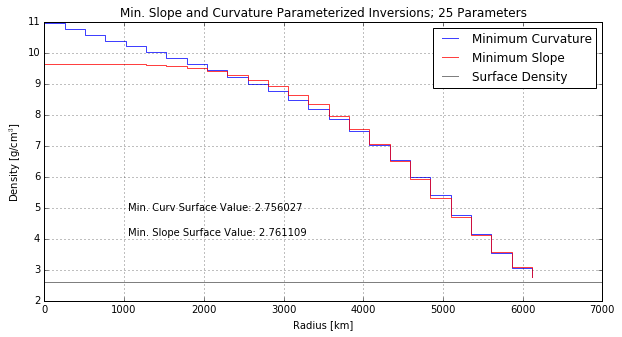

In [9]:
#plot data
fig, ax = plt.subplots(figsize=(10,5))
ax.step(np.arange(0,R,R/N), minCurv(d,N,surfDamp,surfFlatt), where='post',alpha=0.75, label='Minimum Curvature')
ax.step(np.arange(0,R,R/N), minSlope(d,N,surfDamp), where='post',alpha=0.75, c='r', label='Minimum Slope')
ax.axhline(y=rhoSurf, c='black', alpha=0.5, label='Surface Density')
ax.set_xlabel('Radius [km]')
ax.set_ylabel('Density [g/cm$^3$]')
ax.set_title('Min. Slope and Curvature Parameterized Inversions; %d Parameters' %N)
ax.grid()
ax.legend()
ax.text(1050,4.9, 'Min. Curv Surface Value: %f' %minCurv(d,N,surfDamp,surfFlatt)[N-1])
ax.text(1050,4.1, 'Min. Slope Surface Value: %f' %minSlope(d,N,surfDamp)[N-1])
plt.show()

### Now lets see what happens when we vary the additional weighting constraints:
Now lets see what happens when we keep the number of parameters constant and vary the value of the two weighting constraints.  The strategy here will be to create a "value matrix" plot, with the surface damping value varying by row while the surface flattening value will vary by column.

In [10]:
#range of constraints to try; SD = surface damping and SF = Surface Flattening
SD,SF = [5e-5,1,10,5e5],[5e-5,1,10,5e5]

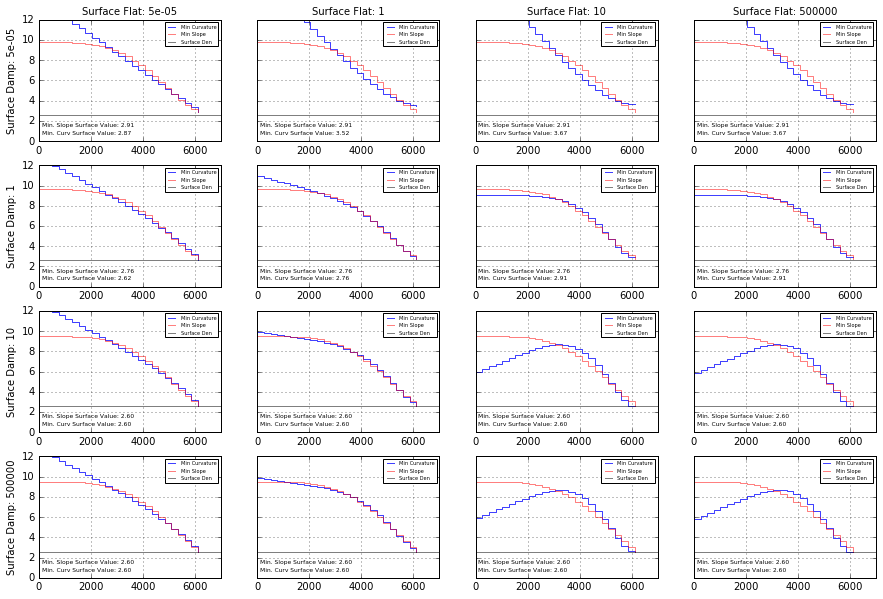

In [11]:
fig, ax = plt.subplots(4,4,figsize=(15,10))
i=0
for row in range(4):
    for col in range(4):
        #print(row,col)
        ax[row,col].step(np.arange(0,R,R/N), minCurv(d,N,SD[row],SF[col]), where='post',
                         alpha=0.75, label='Min Curvature')
        ax[row,col].step(np.arange(0,R,R/N), minSlope(d,N,SD[row]), where='post',
                         alpha=0.5, c='r', label='Min Slope')
        ax[row,col].axhline(y=rhoSurf, c='black', alpha=0.5, label='Surface Den')
        ax[row,col].grid()
        ax[row,col].set_xticks([0,2000,4000,6000])
        ax[row,col].legend(prop={'size': 5})
        ax[row,col].text(100,0.65, 'Min. Curv Surface Value: %.2f' %minCurv(d,N,SD[row],SF[col])[N-1], size=6)
        ax[row,col].text(100,1.4, 'Min. Slope Surface Value: %.2f' %minSlope(d,N,SD[row])[N-1], size=6)
        ax[row,col].set_ylim([0,12])
        if col > 0:
            ax[row,col].set_yticklabels([])
        if col == 0:
            ax[row,col].set_ylabel('Surface Damp: %g' %SD[row])
        if row == 0:
            ax[row,col].set_xlabel('Surface Flat: %g' %SF[col])
            ax[row,col].xaxis.set_label_position('top')
        i += 1

##### Comments:
First, looking at the minimum slope solution only (red curve), we can see that the solution trends towards the base model value as we increase the value of the surface damping constraint (value increases by row from top to bottom of plot).  This is to be expected as we are putting a higher weight on the model parameter at higher radii - in other words, we are trying make the solution honor the model at the surface.  The final run of the inversion with a surface damping value of 500,000 (way too high!) gives a surface density equal to that of the base model, compared to the first run (value of $5\times 10^{-5}$) of 2.91 $g/cm^3$ indicating that heavily damping the model parameters at the surface does in fact force the solution to match the model at that location.

Next, looking at only the minimum curvature results (blue curve), we can see the influence of the surface damping and flattening constraints working together to produce a final solution.  With a small damping constraint and increasing flattening value (top row of graph), the solution does not approximate the surface density well, but does flatten out to a relatively constant value at higher radii.  In comparison, with a higher damping value, such as in the third row of the graph, the solution tends to honor the model value while also showing signs of increasing flattening towards the surface.

In summary, the damping and flattening constraints provided in the weighting matrix do exactly what they are expected to do and prove to be a powerful method for manipulating the parameterized inversion. 

### Now lets see what happens when we vary the number of parameters:
The other variable that we can change is the number of layer parameters used in the inversion.  Below is a graphical display of the solution obtained by only varying the number of parameters used while holding the weighting matrix values constant (both at 1).

In [12]:
#range of layer parameters to try
NRange = [5,15,25,200]

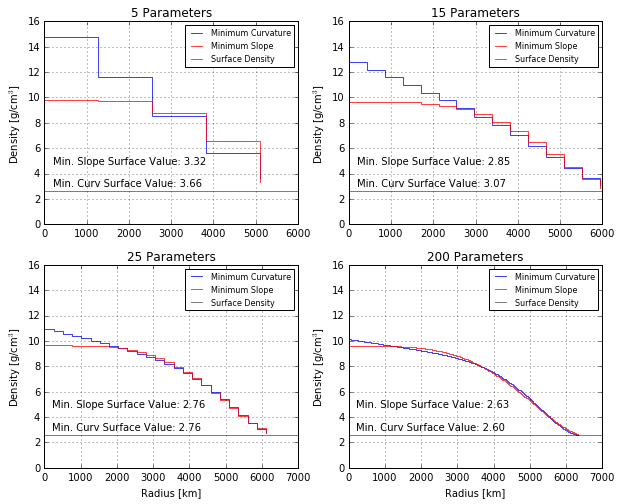

In [13]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
i=0
for row in range(2):
    for col in range(2):
        #print(row,col, i)
        ax[row,col].step(np.arange(0,R,R/NRange[i]), minCurv(d,NRange[i],surfDamp,surfFlatt), where='post',
                         alpha=0.75, label='Minimum Curvature')
        ax[row,col].step(np.arange(0,R,R/NRange[i]), minSlope(d,NRange[i],surfDamp), where='post',
                         alpha=0.75, c='r', label='Minimum Slope')
        ax[row,col].axhline(y=rhoSurf, c='black', alpha=0.5, label='Surface Density')
        ax[row,col].set_ylabel('Density [g/cm$^3$]')
        ax[row,col].set_title('%d Parameters' %NRange[i])
        ax[row,col].grid()
        ax[row,col].legend(prop={'size': 8})
        ax[row,col].text(200,3, 'Min. Curv Surface Value: %.2f' %minCurv(d,NRange[i],surfDamp,surfFlatt)[NRange[i]-1])
        ax[row,col].text(200,4.75, 'Min. Slope Surface Value: %.2f' %minSlope(d,NRange[i],surfDamp)[NRange[i]-1])
        ax[row,col].set_ylim([0,16])
        if row == 1:
            ax[row,col].set_xlabel('Radius [km]')
        
        i += 1

##### Comments:
Interestingly enough, at very low model parameter values, the two solutions differ significantly before beginning to approach each other as the number increases.  It can also be seen that when the number of parameters are lower, the two solutions really live up to their names; as can be seen in the 15 parameter solution, the minimum curvature solution shows almost no undulance while the minimum slope solution attempts to stay as flat as possible.

As expected the final surface density values obtained by each solution also vary with the number of parameters used since the density distribution is being spread across a smaller number of layers.  As the solution approaches that of a continuous inversion, the surface values obtained converge to that of the base model. 